In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

In [3]:
base_image_path = '/content/statueofliberty.jpeg'
result_prefix = "sky_dream"

In [4]:
layer_settings = {
    "mixed4": 2.5,
    "mixed5": 3.0,
    "mixed6": 3.5,
    "mixed7": 4.0
}

step = 0.01
num_octaves = 5
octave_scale = 1.4
iterations = 20
max_loss = 15.0



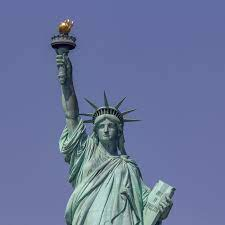

In [5]:
from IPython.display import Image, display

display(Image(base_image_path))

In [6]:
def preprocess(img_path):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)

    return img

def deprocess(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2
    img += 0.5
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")

    return img


In [7]:
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in [model.get_layer(name) for name in layer_settings.keys()]])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

87916544/87910968 [==============================] - 1s 0us/step


In [8]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())

    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling

        return loss


In [9]:
@tf.function
def gradient_ascent_step(img, lr):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    
    grads = tape.gradient(loss, img)
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += lr * grads
    
    return loss, img

def gradient_ascent_loop(img, iterations, lr, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, lr)
        if max_loss is not None and loss > max_loss:
            break
        print(f"Iteration {i} --- Loss - {loss}")

    return img
    

In [10]:
original_img = preprocess(base_image_path)
original_shape = original_img.shape[1:3]
sucessive_shapes = [original_shape]

for i in range(1, num_octaves):
    shape = tuple([int(dim / octave_scale ** i) for dim in original_shape])
    sucessive_shapes.append(shape)
sucessive_shapes = sucessive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, sucessive_shapes[0])
img = tf.identity(original_img)

for i, shape in enumerate(sucessive_shapes):
    print(f"Processing Octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(img, iterations=iterations, lr=step, max_loss=max_loss)
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = upscaled_shrunk_original_img - same_size_original

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img(result_prefix + ".jpg", deprocess(img.numpy()))

Processing Octave 0 with shape (58, 58)
Iteration 0 --- Loss - 0.0
Iteration 1 --- Loss - 0.0
Iteration 2 --- Loss - 0.0
Iteration 3 --- Loss - 0.0
Iteration 4 --- Loss - 0.0
Iteration 5 --- Loss - 0.0
Iteration 6 --- Loss - 0.0
Iteration 7 --- Loss - 0.0
Iteration 8 --- Loss - 0.0
Iteration 9 --- Loss - 0.0
Iteration 10 --- Loss - 0.0
Iteration 11 --- Loss - 0.0
Iteration 12 --- Loss - 0.0
Iteration 13 --- Loss - 0.0
Iteration 14 --- Loss - 0.0
Iteration 15 --- Loss - 0.0
Iteration 16 --- Loss - 0.0
Iteration 17 --- Loss - 0.0
Iteration 18 --- Loss - 0.0
Iteration 19 --- Loss - 0.0
Processing Octave 1 with shape (81, 81)
Iteration 0 --- Loss - 0.0
Iteration 1 --- Loss - 0.0
Iteration 2 --- Loss - 0.0
Iteration 3 --- Loss - 0.0
Iteration 4 --- Loss - 0.0
Iteration 5 --- Loss - 0.0
Iteration 6 --- Loss - 0.0
Iteration 7 --- Loss - 0.0
Iteration 8 --- Loss - 0.0
Iteration 9 --- Loss - 0.0
Iteration 10 --- Loss - 0.0
Iteration 11 --- Loss - 0.0
Iteration 12 --- Loss - 0.0
Iteration 13 ---